# **Trabajo 4 Técnicas en Aprendizaje Estadístico**

## Predicción del número de vehículos registrados diariamente en el Registro Único Nacional de Tránsito

**Realizado por: Alejandro Ortiz Mejía**

Para más detalles acerca del procedimiento en este notebook, consulte https://aljeandro.github.io/trabajo4-TAE/

Importar todas las librerías necesarias.

In [1]:
!pip install darts

     |████████████████████████████████| 235 kB 5.0 MB/s 
     |████████████████████████████████| 62 kB 749 kB/s 
     |████████████████████████████████| 142 kB 56.6 MB/s 
     |████████████████████████████████| 9.5 MB 48.7 MB/s 
     |████████████████████████████████| 177 kB 66.5 MB/s 
     |████████████████████████████████| 1.5 MB 41.6 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 65 kB 3.4 MB/s 
     |████████████████████████████████| 787 kB 52.8 MB/s 
     |████████████████████████████████| 28.5 MB 51 kB/s 
     |████████████████████████████████| 10.3 MB 23.9 MB/s 
     |████████████████████████████████| 9.9 MB 30.7 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 370 kB 75.8 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
     |████████████████████████████████| 178 kB 69.0 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=11

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from darts.models import *
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape, mase, rmse
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from sklearn.metrics import mean_squared_error, r2_score

Cargar el conjunto de datos

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Universidad/Técnicas en aprendizaje estadístico/Trabajos/Trabajo 4/registros_autos_entrenamiento.csv", sep=";")
df.head()

,Fecha,Unidades
0,1/01/2012,0
1,2/01/2012,188
2,3/01/2012,482
3,4/01/2012,927
4,5/01/2012,1159


Convertir el conjunto de datos en un objeto TimeSeries de la librería Darts. Además, se dividen los datos entre entrenamiento y validación.

In [3]:
series = TimeSeries.from_dataframe(df, 'Fecha', 'Unidades')

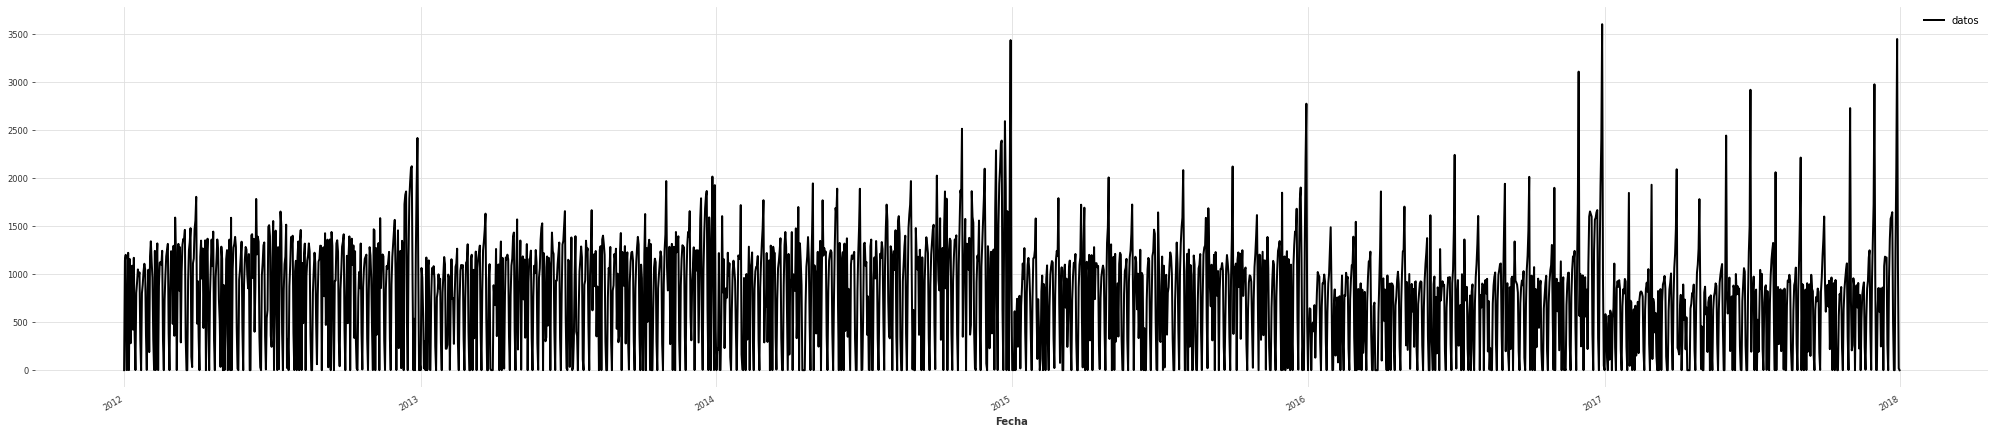

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(label='datos', ax=ax)

Se agrupa el conjunto de datos de manera mensual para ver la serie de tiempo de manera mensual.

In [ ]:
df_mensual = df[:]
df_mensual['Fecha'] = pd.to_datetime(df_mensual['Fecha'], format='%d/%m/%Y')
df_mensual = df_mensual.set_index('Fecha')
df_mensual = df_mensual.groupby(pd.Grouper(freq='M', origin='start')).sum()
series_mensual = TimeSeries.from_dataframe(df_mensual.reset_index()[['Fecha', 'Unidades']], 'Fecha', 'Unidades')

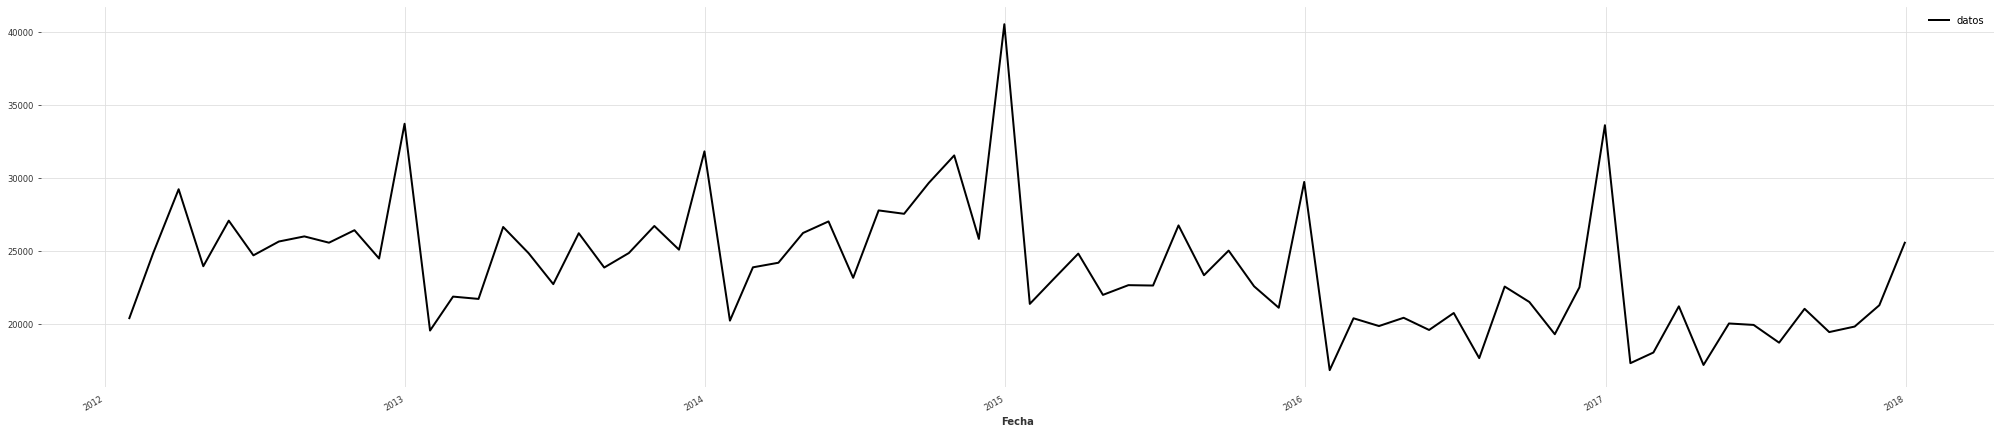

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series_mensual.plot(label='datos', ax=ax)

A continuación, vemos el número de vehículos inscritos cada año.

In [ ]:
df_anual = df[:]
df_anual['Fecha'] = pd.to_datetime(df_anual['Fecha'], format='%d/%m/%Y')
df_anual = df_anual.set_index('Fecha')
df_anual = df_anual.groupby(pd.Grouper(freq='A', origin='start')).sum()
df_anual

,Unidades
Fecha,
2012-12-31,311920
2013-12-31,295803
2014-12-31,327478
2015-12-31,284916
2016-12-31,254893
2017-12-31,239497


A continuación, vemos la gráfica de autocorrelación de enero de 2012.

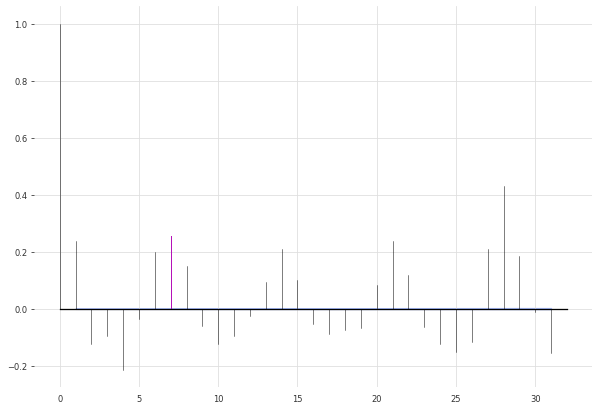

In [ ]:
plot_acf(series, m = 7, max_lag=31, alpha = .05, fig_size=(10, 7))

En la siguiente gráfica se aprecia que existe una tendencial estacional anual muy fuerte, es decir, se presenta una inscripción de carros ante el RUNT con una intensidad muy similar año a año.

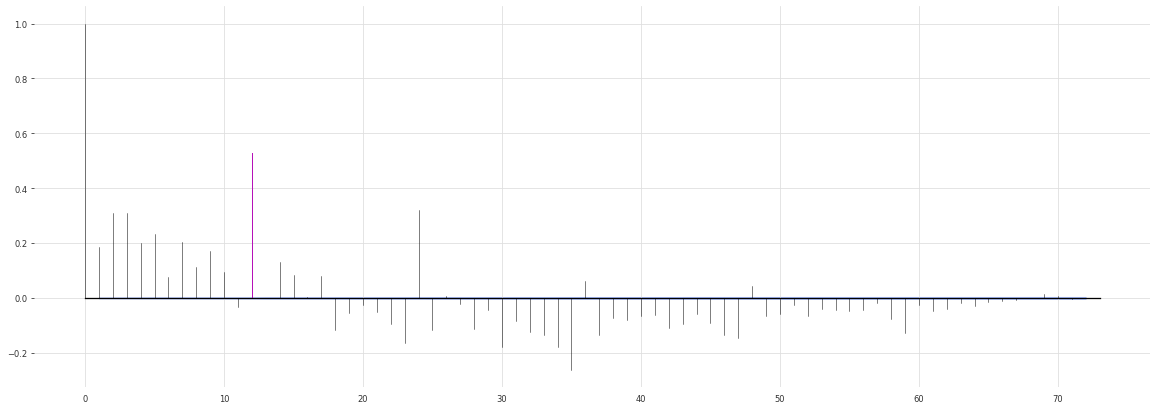

In [ ]:
plot_acf(series_mensual, m = 12, max_lag=72, alpha = .20, fig_size=(20, 7))

## **Creación, entrenamiento y validación del modelo**

## **Año 2017**

Se crea el modelo con el cual se hará la validación con el año 2017. Este modelo utiliza un regresor, que en este caso será un bosque aleatorio. Además, se pasa como parámetro 365 que corresponde a los lags, es decir, el número de días anteriores que serán usados para predecir el siguiente.

In [ ]:
train_2017, val_2017 = series[:-365], series[-365:]

In [ ]:
val_2017_1 = series[1827:2008]

In [ ]:
model_validation_2017 = random_forest.RandomForest(lags=365, n_estimators=500, max_depth=30)
model_validation_2017.fit(train_2017, verbose=True)

Con el siguiente código se puede encontrar la mejor combinación de los hiper parámetros para hallar el mejor modelo, esto se logra mediante la combinación de todos los hiperparámetros contenidos en el diccionario llamado *parameters*. Sin embargo, esta poderosa herramienta **NO** será utilizada para este proyecto, debido a que su ejecución podría tomar incluso varios días a medida que la cantidad de posibles hiperparámetros crece.

In [ ]:
parameters= {
    'n_estimators': [200, 500],
    'max_depth': [20, 30],
    'lags': [365, 730]
}

best_model = random_forest.RandomForest.gridsearch(
                        parameters=parameters,
                        series=train,
                        forecast_horizon=365,
                        metric=mape,
                        verbose=True)

### **Predicción**

Se predicen los siguientes 365 días después del último día de entrenamiento; es decir, se predice todo el 2017.

In [ ]:
prediction_2017 = model_validation_2017.predict(365)

In [ ]:
prediction_semestre1_2017 = model_validation_2017.predict(181)

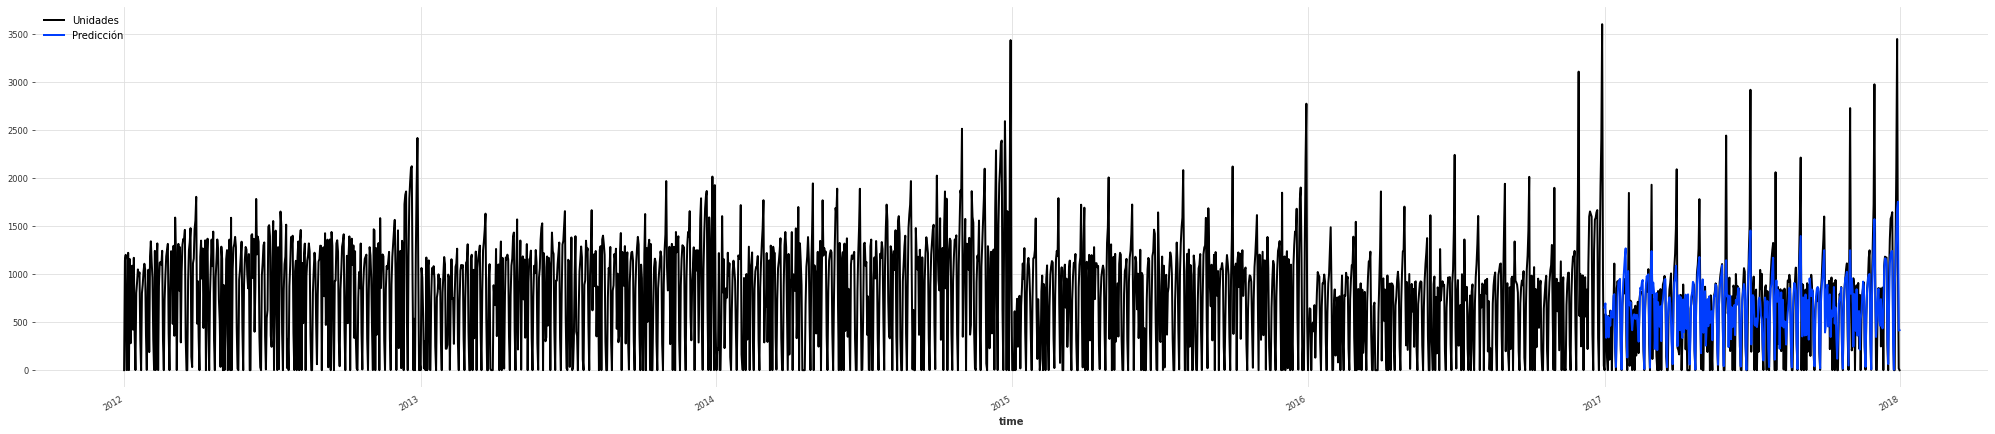

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(ax=ax)
prediction_2017.plot(label='Predicción')

In [ ]:
prediction_2017_df = prediction_2017.pd_dataframe()
df_mensual_2017 = prediction_2017_df.groupby(pd.Grouper(freq='M', origin='start')).sum()
series_mensual_2017 = TimeSeries.from_dataframe(df_mensual_2017.reset_index()[['time', 'Unidades']], 'time', 'Unidades')

In [ ]:
val_2017_df = val_2017.pd_dataframe()
df_val_mensual_2017 = val_2017_df.groupby(pd.Grouper(freq='M', origin='start')).sum()
series_val_mensual_2017 = TimeSeries.from_dataframe(df_val_mensual_2017.reset_index()[['Fecha', 'Unidades']], 'Fecha', 'Unidades')

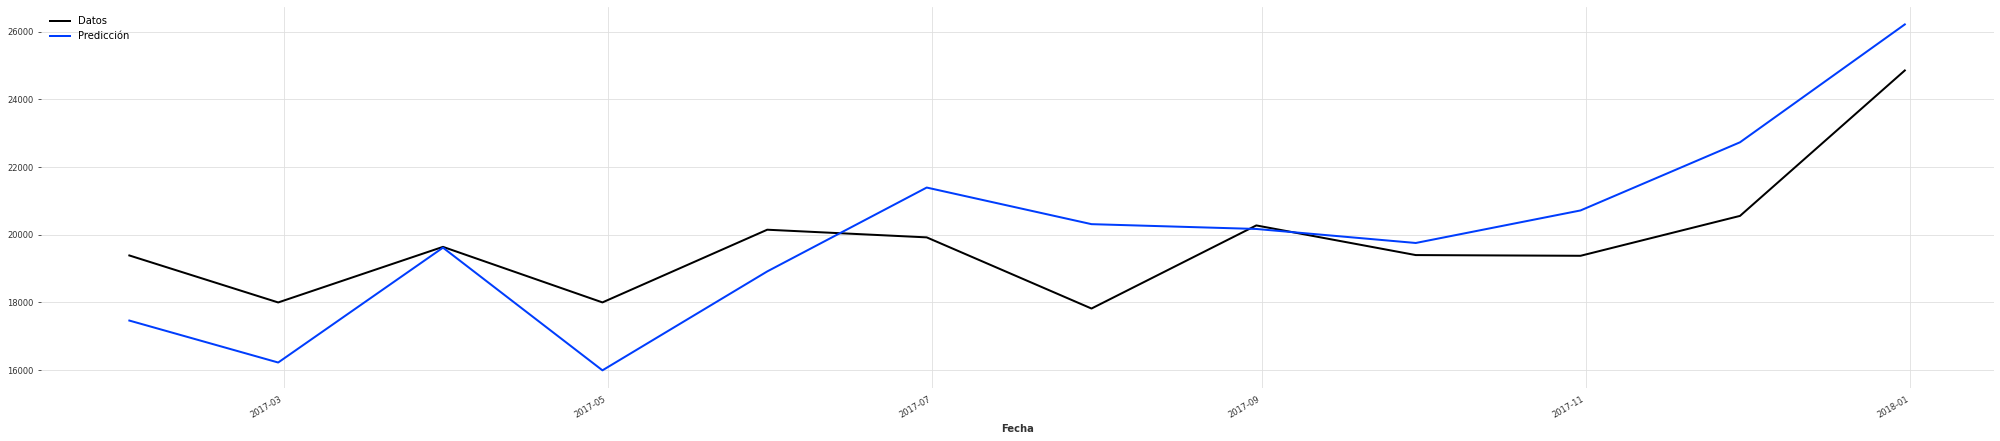

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series_mensual_2017.plot(label='Datos', ax=ax)
series_val_mensual_2017.plot(label='Predicción')

### **Métricas**

**Año 2017 completo**

In [ ]:
rmse_prediction_2017 = rmse(val_2017, prediction_2017)
print(f"El RMSE para la predicción del 2017 es {round(rmse_prediction_2017, 2)}")

El RMSE para la predicción del 2017 es 361.3


In [ ]:
y_true = val_2017.pd_dataframe()['Unidades'].to_list()
y_pred = prediction_2017.pd_dataframe()['Unidades'].to_list()
r_squared_2017 = r2_score(y_true = y_true, y_pred = y_pred)

print(f"El R cuadrado para la predicción del 2017 es: {round(r_squared_2017,2)*100} %")

El R cuadrado para la predicción del 2017 es: 53.0 %


**Primer semestre del 2017**

In [ ]:
rmse_prediction_2017_1 = rmse(val_2017_1, prediction_semestre1_2017)
print(f"El RMSE para la predicción del primer semestre de 2017 es {round(rmse_prediction_2017_1, 2)}")

El RMSE para la predicción del primer semestre de 2017 es 344.21


In [ ]:
y_true_2017_1 = val_2017_1.pd_dataframe()['Unidades'].to_list()
y_pred_2017_1 = prediction_semestre1_2017.pd_dataframe()['Unidades'].to_list()
r_squared_2017_1 = r2_score(y_true = y_true_2017_1, y_pred = y_pred_2017_1)

print(f"El R cuadrado para la predicción del primer semestre de 2017 es: {round(r_squared_2017_1, 2)*100} %")

El R cuadrado para la predicción del primer semestre de 2017 es: 49.0 %


## **Predicción primer semestre de 2018**

In [4]:
model_2018 = random_forest.RandomForest(lags=365, n_estimators=500, max_depth=30)
model_2018.fit(series)

In [5]:
prediction_2018_1 = model_2018.predict(181)

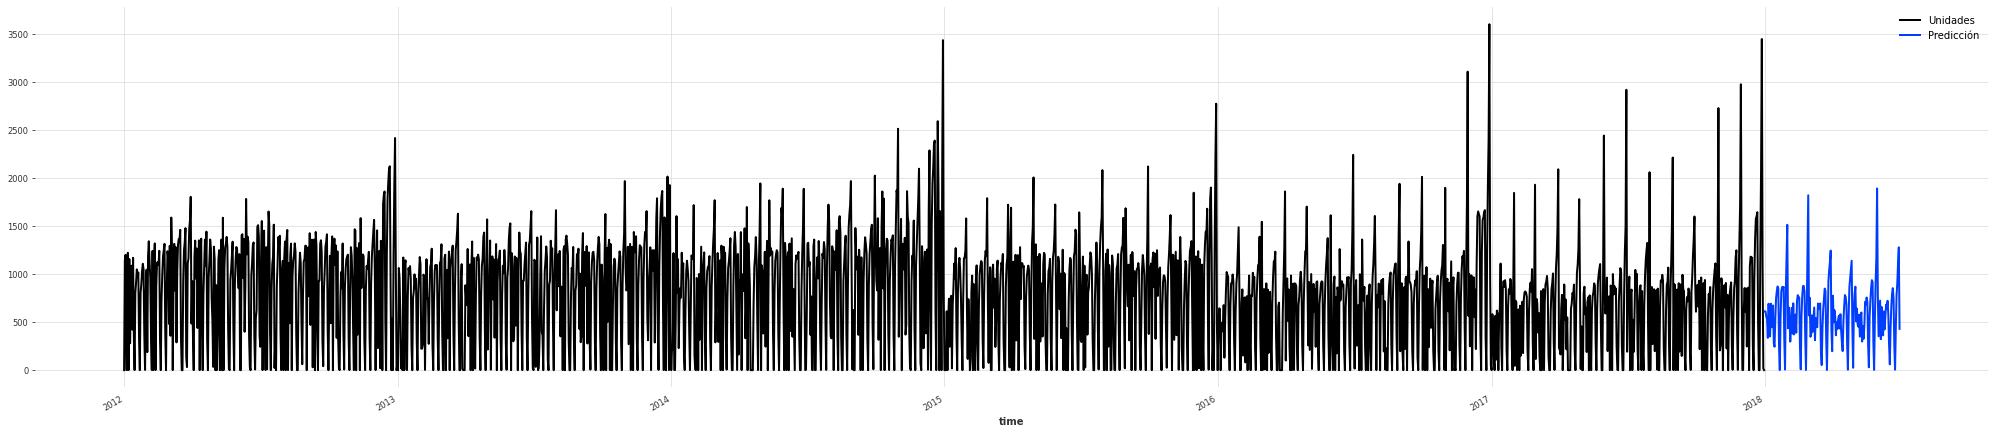

In [6]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(ax=ax)
prediction_2018_1.plot(label='Predicción')

Se guarda un archivo excel con las predicciones del primer semestre del año 2018.

In [7]:
prediction_2018_1.pd_dataframe().to_excel('prediccion_2018.xlsx')

## **Predicción de todo el año 2018**

In [8]:
prediction_2018 = model_2018.predict(365)

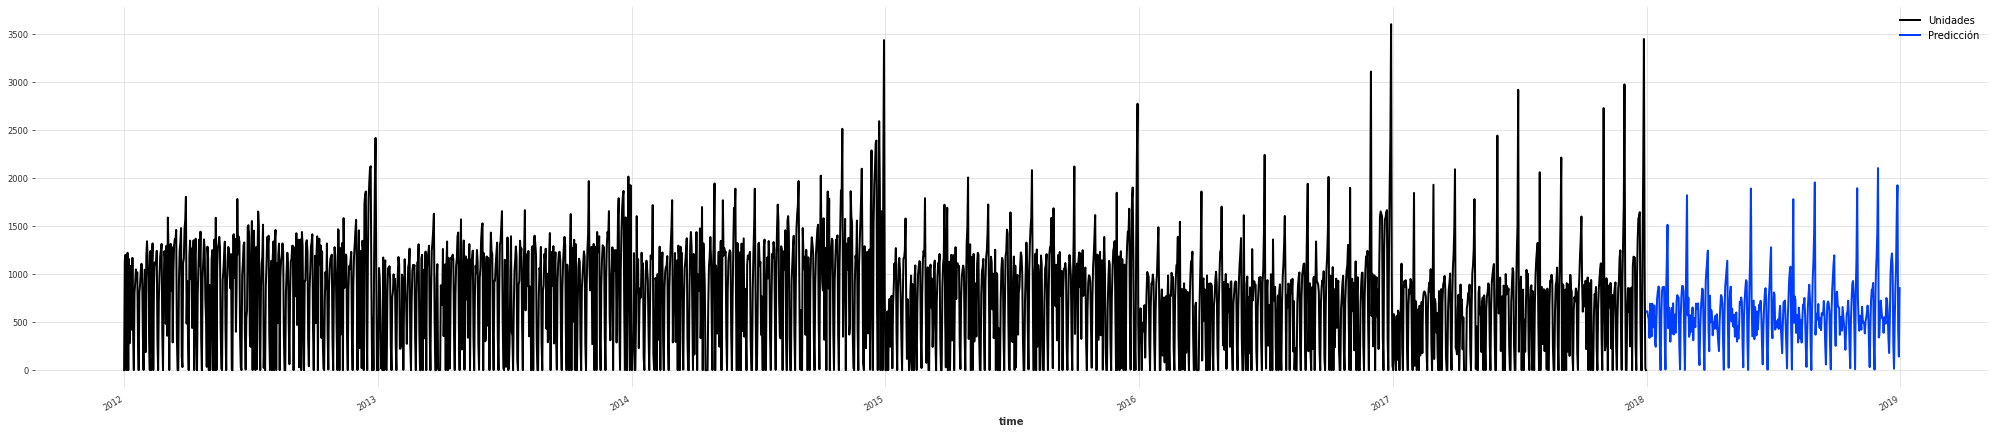

In [9]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(ax=ax)
prediction_2018.plot(label='Predicción')

## **Predicción periodo 2012 - 2016**

**Predicción del 2016**

In [ ]:
train_2016, val_2016 = series[:1461], series[1461:1827]

In [ ]:
model_2016 = random_forest.RandomForest(lags=365, n_estimators=1000, max_depth=30)
model_2016.fit(train_2016)

In [ ]:
prediction_2016 = model_2016.predict(len(val_2016))

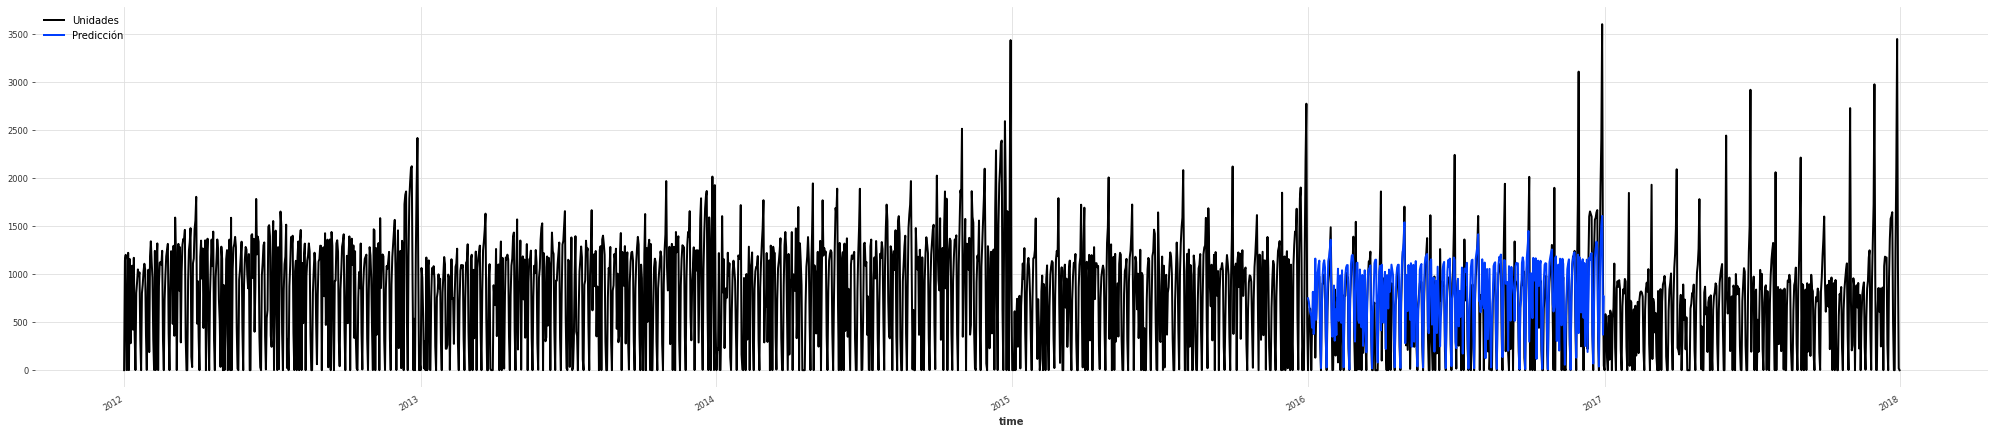

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(ax=ax)
prediction_2016.plot(label='Predicción')

In [ ]:
y_true = val_2016.pd_dataframe()['Unidades'].to_list()
y_pred = prediction_2016.pd_dataframe()['Unidades'].to_list()
r_squared_2016 = r2_score(y_true = y_true, y_pred = y_pred)

print(f"El R cuadrado para la predicción del 2016 es: {round(r_squared_2016,2)*100} %")

El R cuadrado para la predicción del 2016 es: 33.0 %


**Predicción 2015**

In [ ]:
train_2015, val_2015 = series[:1096], series[1096:1461]

In [ ]:
model_2015 = random_forest.RandomForest(lags=365, n_estimators=500, max_depth=30)
model_2015.fit(train_2015)

In [ ]:
prediction_2015 = model_2015.predict(len(val_2015))

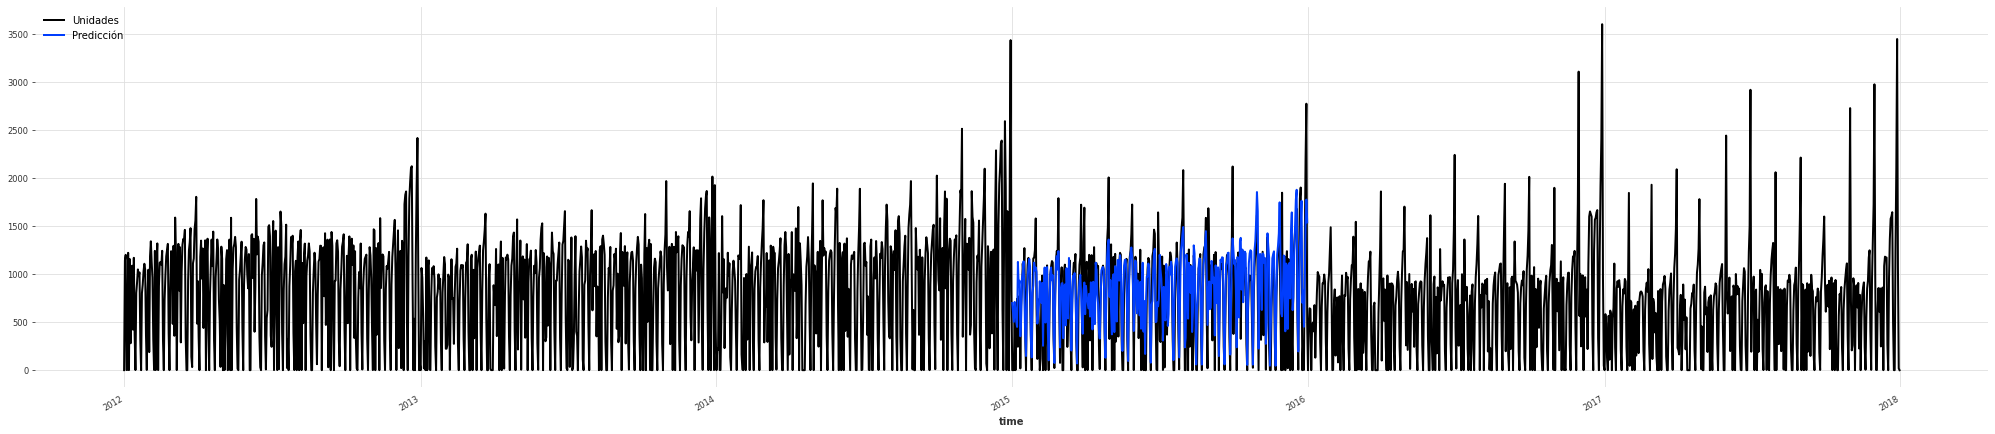

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(ax=ax)
prediction_2015.plot(label='Predicción')

In [ ]:
y_true_2015 = val_2015.pd_dataframe()['Unidades'].to_list()
y_pred_2015 = prediction_2015.pd_dataframe()['Unidades'].to_list()
r_squared_2015 = r2_score(y_true = y_true_2015, y_pred = y_pred_2015)

print(f"El R cuadrado para la predicción del 2015 es: {round(r_squared_2015,2)*100} %")

El R cuadrado para la predicción del 2015 es: 52.0 %


**Predicción 2014**

In [ ]:
train_2014, val_2014 = series[:731], series[731:1096]

In [ ]:
model_2014 = random_forest.RandomForest(lags=365, n_estimators=500, max_depth=30)
model_2014.fit(train_2014)

In [ ]:
prediction_2014 = model_2014.predict(len(val_2014))

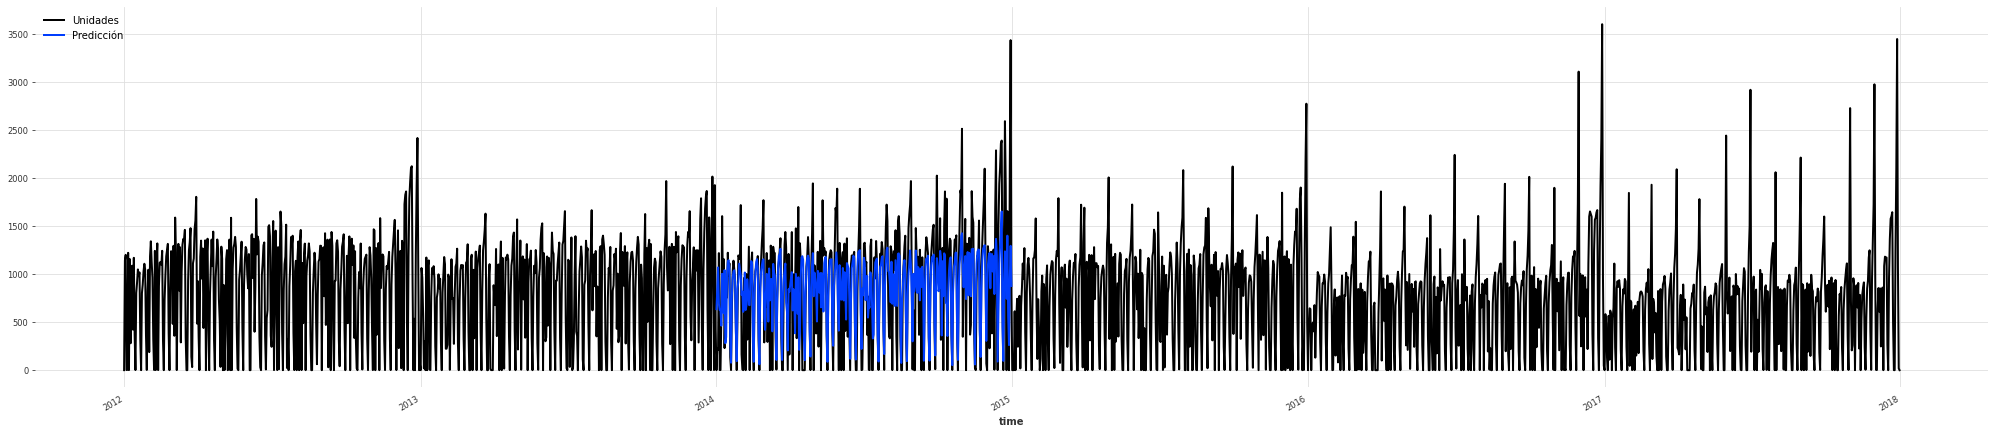

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(ax=ax)
prediction_2014.plot(label='Predicción')

In [ ]:
y_true_2014 = val_2014.pd_dataframe()['Unidades'].to_list()
y_pred_2014 = prediction_2014.pd_dataframe()['Unidades'].to_list()
r_squared_2014 = r2_score(y_true = y_true_2014, y_pred = y_pred_2014)

print(f"El R cuadrado para la predicción del 2014 es: {round(r_squared_2014,2)*100} %")

El R cuadrado para la predicción del 2014 es: 49.0 %


**Predicción 2012 y 2013**

In [ ]:
train_2012_2013 = series[:731]

In [ ]:
model_2012_2013 = random_forest.RandomForest(lags=90, n_estimators=500, max_depth=30)
predictions_2012_2013 = model_2012_2013.historical_forecasts(train_2012_2013, start=91, stride=1, forecast_horizon=1, verbose=True)

100%|██████████| 640/640 [1:15:20<00:00,  7.06s/it]


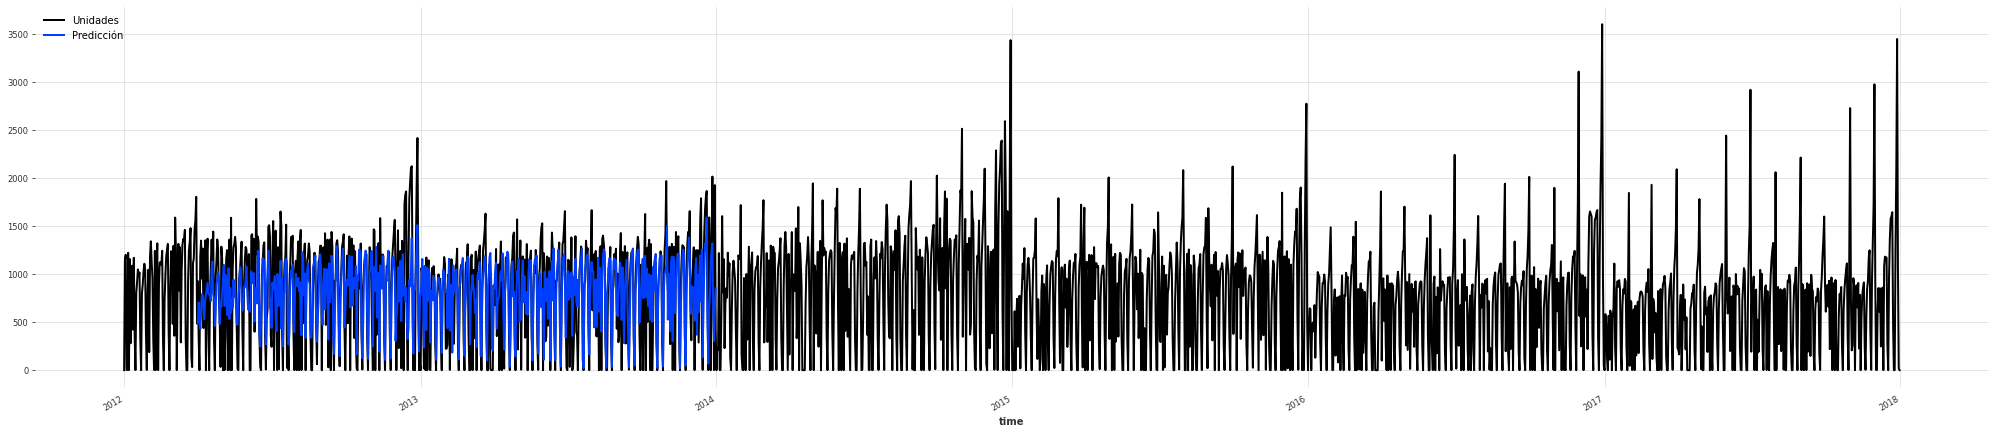

In [ ]:
fig, ax=plt.subplots(figsize=(35, 7))
series.plot(label='Unidades', ax=ax)
predictions_2012_2013.plot(label='Predicción')
plt.legend()
plt.show()

In [ ]:
val_2012_2013 = series[91:731]

In [ ]:
predictions_2012_2013_df = predictions_2012_2013.pd_dataframe()
predictions_2012_2013_df.columns = ['Unidades']

In [ ]:
y_true_2012_2013 = val_2012_2013.pd_dataframe()['Unidades'].to_list()
y_pred_2012_2013 = predictions_2012_2013_df['Unidades'].to_list()
r_squared_2012_2013 = r2_score(y_true = y_true_2012_2013, y_pred = y_pred_2012_2013)

print(f"El R cuadrado para la predicción del periodo desde el segundo trimestre de 2012 hasta el 2013 (incluyendolo) es: {round(r_squared_2012_2013,2)*100} %")

El R cuadrado para la predicción del periodo desde el segundo trimestre de 2012 hasta el 2013 (incluyendolo) es: 39.0 %


Se duplican las predicciones para el primer semestre de 2013 para las predicciones del primer trimestre de 2012

In [ ]:
fechas_triemestre1_2012 = pd.date_range(start='1/1/2012', end='31/3/2012', freq='D')
df_trimestre1_2012 = pd.DataFrame(list(zip(fechas_triemestre1_2012, predictions_2012_2013_df['2013-01-01':'2013-04-01']['Unidades'])), columns=['time', 'Unidades'])
df_trimestre1_2012 = df_trimestre1_2012.set_index('time')

Se concatenan los resultados de todos los años predichos.

In [ ]:
predictions_2012_2016 = pd.concat([df_trimestre1_2012, predictions_2012_2013_df, prediction_2014.pd_dataframe(), prediction_2015.pd_dataframe(), prediction_2016.pd_dataframe()]).sort_index()

In [ ]:
y_true_2012_2016 = series[:1827].pd_dataframe()['Unidades'].to_list()
y_pred_2012_2016 = predictions_2012_2016['Unidades'].to_list()
r_squared_2012_2016 = r2_score(y_true = y_true_2012_2016, y_pred = y_pred_2012_2016)
print(f"El R cuadrado para la predicción del periodo 2012 - 2016 es: {round(r_squared_2012_2016,2)*100} %")

El R cuadrado para la predicción del periodo 2012 - 2016 es: 40.0 %


In [ ]:
rmse_prediction_2012_2016 = rmse(series[:1827], TimeSeries.from_dataframe(predictions_2012_2016))
print(f"El RMSE para la predicción del periodo 2012 - 2016 es: {round(rmse_prediction_2012_2016, 2)}")

El RMSE para la predicción del periodo 2012 - 2016 es: 429.36


Se guarda un archivo excel con las predicciones del periodo 2012 al 2016.

In [ ]:
predictions_2012_2016.to_excel('prediccion_2012_2016.xlsx')